# Data-driven calibration of transition viability thresholds

We used the hierarchy of occupations inherent in the ESCO data set to derive a data-driven threshold for viable transitions along with an additional indicator for transitions that are highly viable.

# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble_Transitions.ipy
import mapping_career_causeways.plotting_utils as plotting_utils
from scipy.stats import percentileofscore
from itertools import combinations

data = load_data.Data()

In [2]:
def flatten_without_diagonal(W):
    """
    Return all matrix's W values, except the diagonal, in a flat vector, 
    """
    return np.concatenate((
        W[np.triu_indices(W.shape[0], k=1)],
        W[np.tril_indices(W.shape[0], k=-1)]))    

In [3]:
# Import occupation table
occupations = data.occupation_hierarchy

# Combined similarity measure
W = load_data.Similarities().W_combined

In [4]:
occupations.head(1)

,id,concept_type,concept_uri,preferred_label,isco_level_1,isco_level_2,isco_level_3,isco_level_4,is_top_level,is_second_level,is_third_level,is_fourth_level,parent_occupation_id,top_level_parent_id
0,0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,technical director,2,21,216,2166,False,True,False,False,2408.0,2408


# 1. Calibrate viability treshold

We set the threshold for viability to correspond to the typical similarity between closely related occupations
that belong to the same ISCO unit group. For example, shop assistants and sales processors are both in the ISCO unit group ‘Shop sales assistants’ with the four-digit code 5223, and it is reasonable to assume that the transition between these two occupations should be viable.

We calculated the average within-group occupation similarity for each ISCO unit group that had more than one occupation (using the combined similarity measure) and used the distribution of these within-group averages to make a judgement on the viability threshold. In the interest of obtaining more robust estimates of within-group averages, we used all occupations from the ESCO framework.

In [5]:
# Occupational hierarchy level that we are using (here, ISCO unit groups)
group_category = 'isco_level_4'

# Get all parent occupations *with at least 1 child*
df = occupations.groupby(group_category).count()
parents_with_children = df[df.id>1].index.to_list()

### Calculate within-group similarity 

# similarity values
w_same_group = [] 
# compared occupation IDs
pairs = []
# list of lists for each group of occupations
w_within_groups = []

for j in range(len(parents_with_children)):
    
    ids = occupations[occupations[group_category] == parents_with_children[j]].id.to_list()
    w_within_group = []
    
    for pair in list(combinations(ids,2)):
        
        # Transitions in both directions
        w_same_group.append(W[pair])
        pairs.append(pair)
        
        w_same_group.append(W[(pair[1],pair[0])])
        pairs.append((pair[1],pair[0]))    
        
        # List of lists, storing each groups within-group similarities
        w_within_group.append(W[pair])
        w_within_group.append(W[(pair[1],pair[0])])            
        
    w_within_groups.append(w_within_group)


In [6]:
# Calculate the average within-group similarity for each group of occupations
mean_within_group_sim = [np.mean(y) for y in w_within_groups]


In [7]:
# Median & mean average-within-group similarities
print(np.median(mean_within_group_sim))
print(np.mean(mean_within_group_sim))

0.4464874478887421
0.4771832452168944


In [8]:
# Check the spread of the aveage-within-group similarities (in terms of standard deviations)
print(f'-2SD: {np.mean(mean_within_group_sim) - 2*np.std(mean_within_group_sim) :.3f}')
print(f'-1.5SD: {np.mean(mean_within_group_sim) - 1.5*np.std(mean_within_group_sim) :.3f}')
print(f'-1SD: {np.mean(mean_within_group_sim) - 1*np.std(mean_within_group_sim) :.3f}')
print(f'0SD: {np.mean(mean_within_group_sim) :.2f}')
print(f'+1SD: {np.mean(mean_within_group_sim) + 1*np.std(mean_within_group_sim) :.3f}')
print(f'+1.5SD: {np.mean(mean_within_group_sim) + 1.5*np.std(mean_within_group_sim) :.3f}')
print(f'+2SD: {np.mean(mean_within_group_sim) + 2*np.std(mean_within_group_sim) :.3f}')

-2SD: 0.150
-1.5SD: 0.231
-1SD: 0.313
0SD: 0.48
+1SD: 0.641
+1.5SD: 0.723
+2SD: 0.805


Interestingly, there was considerable variation across different ISCO unit groups, and hence we set the viability threshold as the mean minus one standard deviation of these within-group averages (rounded to the first decimal point). This yielded a viability threshold equal to 0.30, with approximately 80 per cent of the within-group transitions above this threshold.

In [9]:
VIABILITY_THRESHOLD = np.round(np.mean(mean_within_group_sim) - 1*np.std(mean_within_group_sim), 1)
print(VIABILITY_THRESHOLD)

0.3


In [10]:
# Fraction of transitions above this threshold
all_w = [x for y in w_within_groups for x in y]
np.sum(np.array(all_w)>VIABILITY_THRESHOLD)/len(all_w)

0.8260183010770102

In [11]:
# Fraction of ISCO unit groups above this threshold
np.sum(np.array(mean_within_group_sim)>VIABILITY_THRESHOLD)/len(mean_within_group_sim)

0.88

## 1.1 Visualise the distribution

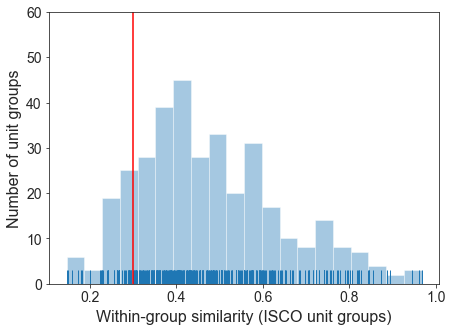

In [12]:
# Distribution of within-group similarities
sns.set_style("ticks")
plt.figure(figsize=(7,5))
sns.distplot(mean_within_group_sim, kde=False, rug=True, bins=20)
# Viability threshold
plt.plot([VIABILITY_THRESHOLD, VIABILITY_THRESHOLD], [0, 60], c='r')

plt.xlabel('Within-group similarity (ISCO unit groups)', fontsize=16)
plt.ylabel('Number of unit groups', fontsize=16)
plt.ylim([0, 60])
plt.tick_params(axis='both', which='major', labelsize=14)
plotting_utils.export_figure('fig_54')

plt.show()

### Check examples

In [13]:
df_isco_titles = pd.DataFrame(data={
    'sim': mean_within_group_sim,
    'isco': parents_with_children}).merge(data.isco_titles[['isco', 'isco_title']], how='left')
df_isco_titles.sort_values('sim')

,sim,isco,isco_title
2,0.146489,310,NaN
218,0.149848,5169,Personal services workers not elsewhere classi...
181,0.158713,3433,"Gallery, museum and library technicians"
271,0.173569,7319,Handicraft workers not elsewhere classified
24,0.179447,1349,Professional services managers not elsewhere c...
...,...,...,...
304,0.887235,8132,Photographic products machine operators
66,0.894454,2330,Secondary education teachers
277,0.945005,7413,Electrical line installers and repairers
67,0.960500,2341,Primary school teachers


# 2. Calibrate highly viable transitions

The ESCO framework defines a further hierarchy of broader and narrower ESCO occupations that goes beyond the
ISCO unit groups (cf. Figure 47, page 85 in the Mapping Career Causeways report). For example, butcher is related to two other, narrower occupations: halal butcher and kosher butcher. We leveraged this hierarchy to
derive an indicator for highly viable transitions by defining ‘broad ESCO groups’ that contain the broad ESCO level
5 occupation and all its narrower occupations (Figure 55, page 94 in the report).

Analogous to the calibration process of the viability threshold, we set the indicator for highly viable transitions equal to the mean minus one standard deviation of the average within-group similarities of all broad ESCO groups rounded to the nearest decimal point.

In [14]:
# Occupational hierarchy level that we are using (here, ISCO unit groups)
group_category = 'top_level_parent_id'

# Get all broader top level parent occupations *with children (narrower occupations)*
df = occupations.groupby(group_category).count()
parents_with_children = df[df.id>1].index.to_list()

## Calculate within-group similarity across all broader top-level occupations

# similarity values
w_same_group = [] 
# compared occupation IDs
pairs = []
# list of lists for each group of occupations
w_within_groups = []

for j in range(len(parents_with_children)):
    
    ids = occupations[occupations[group_category] == parents_with_children[j]].id.to_list()
    w_within_group = []
    
    for pair in list(combinations(ids,2)):        
        w_same_group.append(W[pair])
        pairs.append(pair)
        
        w_same_group.append(W[(pair[1],pair[0])])
        pairs.append((pair[1],pair[0]))    
        
        w_within_group.append(W[pair])
        w_within_group.append(W[(pair[1],pair[0])])            
        
    w_within_groups.append(w_within_group)


In [15]:
# Calculate the average within-group similarity for each group of occupations
mean_within_group_sim = [np.mean(y) for y in w_within_groups]


In [16]:
# Median & mean average-within-group similarities
print(np.median(mean_within_group_sim))
print(np.mean(mean_within_group_sim))

0.5856344816634551
0.5938798793360194


In [17]:
# Standard deviations
print(f'-2SD: {np.mean(mean_within_group_sim) - 2*np.std(mean_within_group_sim) :.2f}')
print(f'-1.5SD: {np.mean(mean_within_group_sim) - 1.5*np.std(mean_within_group_sim) :.2f}')
print(f'-1SD: {np.mean(mean_within_group_sim) - 1*np.std(mean_within_group_sim) :.2f}')
print(f'0SD: {np.mean(mean_within_group_sim) :.2f}')
print(f'+1SD: {np.mean(mean_within_group_sim) + 1*np.std(mean_within_group_sim) :.2f}')
print(f'+1.5SD: {np.mean(mean_within_group_sim) + 1.5*np.std(mean_within_group_sim) :.2f}')
print(f'+2SD: {np.mean(mean_within_group_sim) + 2*np.std(mean_within_group_sim) :.2f}')

-2SD: 0.24
-1.5SD: 0.33
-1SD: 0.42
0SD: 0.59
+1SD: 0.77
+1.5SD: 0.86
+2SD: 0.95


In [18]:
HIGHLY_VIABLE_THRESHOLD = np.round(np.mean(mean_within_group_sim) - 1*np.std(mean_within_group_sim), 1)
print(HIGHLY_VIABLE_THRESHOLD)

0.4


## 2.1 Visualise the distribution

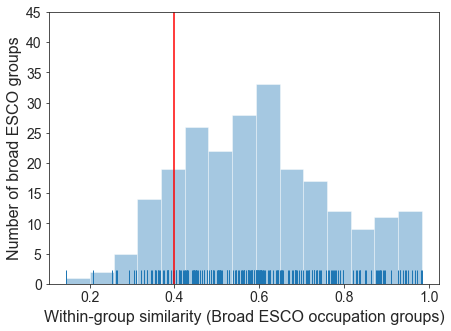

In [19]:
# Distribution of within-group similarities
sns.set_style("ticks")
plt.figure(figsize=(7,5))
sns.distplot(mean_within_group_sim, kde=False, rug=True, bins=15)
plt.plot([HIGHLY_VIABLE_THRESHOLD, HIGHLY_VIABLE_THRESHOLD], [0, 60], c='r')

plt.xlabel('Within-group similarity (Broad ESCO occupation groups)', fontsize=16)
plt.ylabel('Number of broad ESCO groups', fontsize=16)
plt.ylim([0, 45])
plt.tick_params(axis='both', which='major', labelsize=14)
plotting_utils.export_figure('fig_56')
plt.show()


### Check examples

In [20]:
df_occ_titles = pd.DataFrame(data={
    'sim':mean_within_group_sim,
    'id': parents_with_children}).merge(data.occ[['id','preferred_label']], how='left')
df_occ_titles.sort_values('sim')

,sim,id,preferred_label
181,0.145179,2230,service manager
161,0.208920,2005,linguist
121,0.251967,1452,health and safety officer
10,0.262696,148,telephone switchboard operator
195,0.265305,2360,community health worker
...,...,...,...
3,0.960500,55,primary school teacher
180,0.967569,2225,driving instructor
56,0.973510,710,wholesale merchant
197,0.980899,2388,technical sales representative


# 3. Summarise the viability thresholds

Based on the observations above, we define transition similarities in the following way:
- **Viable** transitions have similarity above 0.30. This corresponds to about mean minus one standard deviation of within--group similarity for four-digit ISCO unit groups.
- **Highly viable transitions** have similarity above 0.40. This corresponds to mean minus one standard deviation for within-group similarity for broad ESCO occupation groups.


In [21]:
VIABILITY_THRESHOLD

0.3

In [22]:
HIGHLY_VIABLE_THRESHOLD

0.4

# 4. Visualise the distribution of all similarities

In [23]:
# All transition similarities 
w = flatten_without_diagonal(W)

In [24]:
# Characterise the thresholds with respect to all possible transitions (between all ESCO occupations)
print(f'Viable transitions are in the {percentileofscore(w, VIABILITY_THRESHOLD):.1f} precentile')
print(f'Highly viable transitions are in the {percentileofscore(w, HIGHLY_VIABLE_THRESHOLD):.1f} precentile')

Viable transitions are in the 96.0 precentile
Highly viable transitions are in the 98.7 precentile


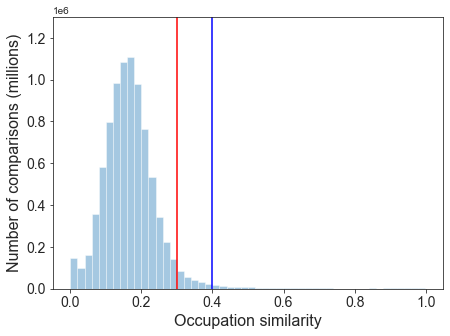

In [25]:
# Distribution of all similarities
sns.set_style("ticks")
plt.figure(figsize=(7,5))
sns.distplot(w, kde=False)

# Viability thresholds
plt.plot([VIABILITY_THRESHOLD, VIABILITY_THRESHOLD], [0, 2e+6], c='r')
plt.plot([HIGHLY_VIABLE_THRESHOLD, HIGHLY_VIABLE_THRESHOLD], [0, 2e+6], c='b')

plt.xlabel('Occupation similarity', fontsize=16)
plt.ylabel('Number of comparisons (millions)', fontsize=16)
plt.ylim([0, 1.3e+6])
plt.tick_params(axis='both', which='major', labelsize=14)
plotting_utils.export_figure('fig_57')
plt.show()